In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go
import os
from PIL import Image

In [2]:
slice_number = 100

In [ ]:
# exp_name = 'P28A_FT_H_Exp1'
# time_step = '190'
# slice_num = '260'
# image_dir = 'Z:/Reconstructions/' + exp_name + '/entry0' + time_step + '_no_extpag_db0100_vol/entry0' + time_step + '_no_extpag_db0100_vol_000' + slice_num + '.tiff'

In [5]:
# Win directories
np_dir = 'Z:/rot_datasets/P28A_FT_H_Exp4_2/entry0000_no_extpag_db0050_vol/volume_v2.npy'
img_dir = 'Z:/Reconstructions/P28A_FT_H_Exp4_2/entry0000_no_extpag_db0050_vol/entry0000_no_extpag_db0050_vol_000' + str(slice_number) + '.tiff'

In [7]:
# Mac directories
np_dir = '../MasterThesisData/rot_datasets/P28A_FT_H_Exp4_2/entry0000_no_extpag_db0050_vol/volume_v2.npy'
img_dir = '../MasterThesisData/Reconstructions/P28A_FT_H_Exp4_2/entry0000_no_extpag_db0050_vol/entry0000_no_extpag_db0050_vol_000' + str(slice_number) + '.tiff'

(280, 902, 902)


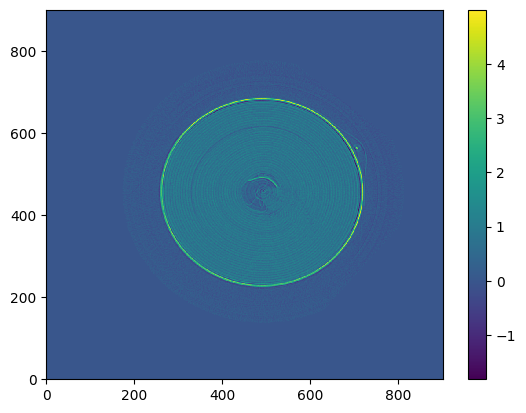

In [8]:
img = np.load(np_dir)
print(img.shape)
plt.pcolormesh(img[slice_number])
plt.colorbar()

(640, 640)


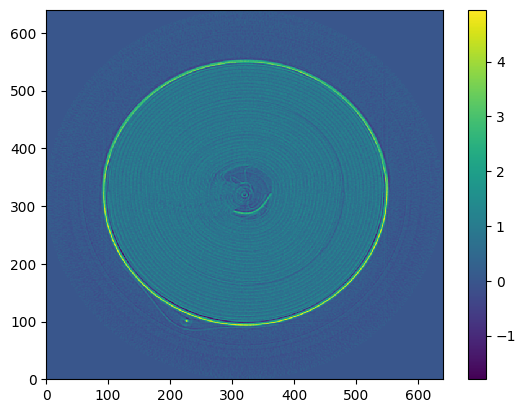

In [9]:
img = Image.open(img_dir)
img = np.array(img)
print(img.shape)
plt.pcolormesh(img)
plt.colorbar()